In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

sns.set_theme(style='whitegrid')

csv_path = Path("../data/FAOSTAT_data_en_10-14-2025.csv")

# Read CSV
df = pd.read_csv(csv_path, dtype=str)

print('Raw rows:', len(df))
print('Columns:', list(df.columns))
print(df.head(3).to_string(index=False))

Raw rows: 1782
Columns: ['Domain Code', 'Domain', 'Area Code (M49)', 'Area', 'Year Code', 'Year', 'Item Code', 'Item', 'Months Code', 'Months', 'Element Code', 'Element', 'Unit', 'Value', 'Flag', 'Flag Description', 'Note']
Domain Code                 Domain Area Code (M49)   Area Year Code Year Item Code                                       Item Months Code   Months Element Code Element Unit     Value Flag                  Flag Description              Note
         CP Consumer Price Indices             124 Canada      2000 2000     23013 Consumer Prices, Food Indices (2015 = 100)        7001  January         6125   Value  NaN 64.948845    X Figure from external organization base year is 2015
         CP Consumer Price Indices             124 Canada      2000 2000     23013 Consumer Prices, Food Indices (2015 = 100)        7002 February         6125   Value  NaN 64.736363    X Figure from external organization base year is 2015
         CP Consumer Price Indices             124 Canad

In [14]:
def load_fao_country(df, country_name, item_keyword='Food Indices'):
    # filters fao data for a single country and item
    # convertds types, creates a date column, drops invalid rows, and returns the changed df
    # colums: date, value, area, item, year, months

    mask = (df['Area'] == country_name) & df['Item'].str.contains(item_keyword, na=False)
    df_country = df.loc[mask].copy()

    # convert Value to numeric and keep Year as string
    df_country['Value'] = pd.to_numeric(df_country['Value'], errors='coerce')
    df_country['Year'] = df_country['Year'].astype(str)

    # parse month name + year into a datetime; coerce invalid combos to NaT
    df_country['date'] = pd.to_datetime(
        df_country['Year'] + ' ' + df_country['Months'],
        format='%Y %B', errors='coerce'
    )

    # trim to useful columns and drop rows missing date or value
    cols_keep = ['date', 'Value', 'Area', 'Item', 'Year', 'Months']
    df_country = df_country.loc[:, df_country.columns.intersection(cols_keep)].dropna(subset=['date', 'Value']).copy()

    df_country = df_country.sort_values('date').reset_index(drop=True)
    return df_country

In [15]:

df_can = load_fao_country(df, 'Canada')
df_us = load_fao_country(df, 'United States of America')
df_mex = load_fao_country(df, 'Mexico')

print('Rows:', 'Canada=', len(df_can), 'US=', len(df_us), 'Mexico=', len(df_mex))

Rows: Canada= 303 US= 303 Mexico= 303


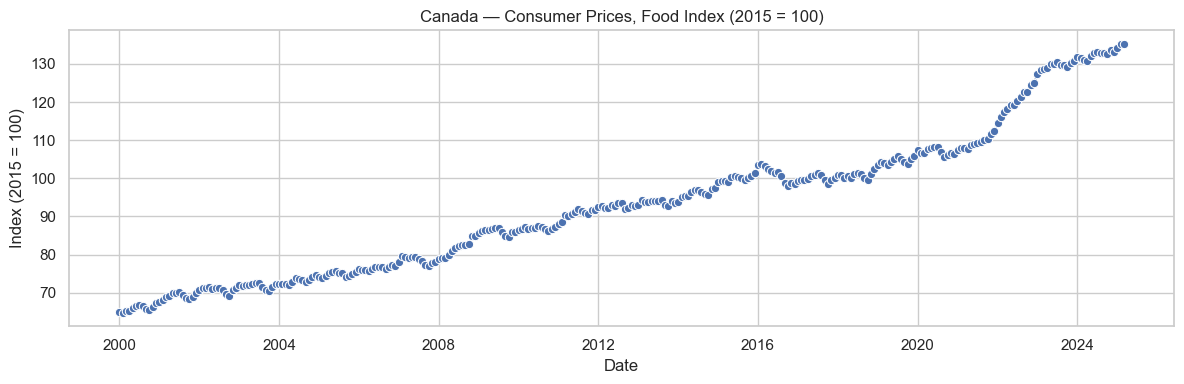

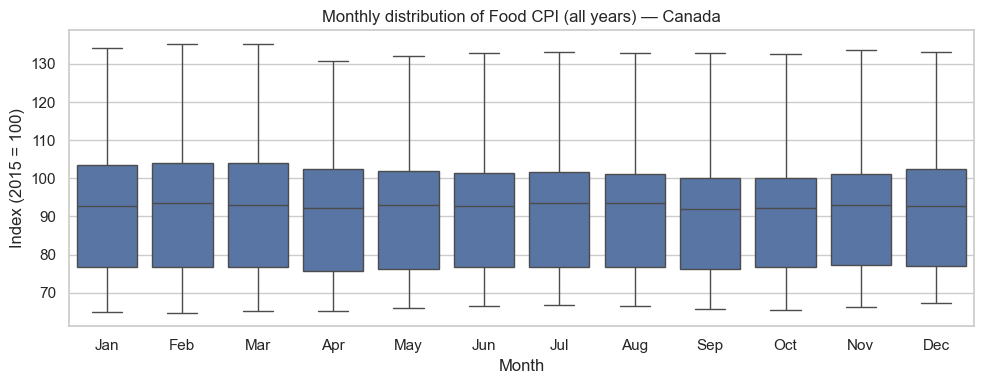

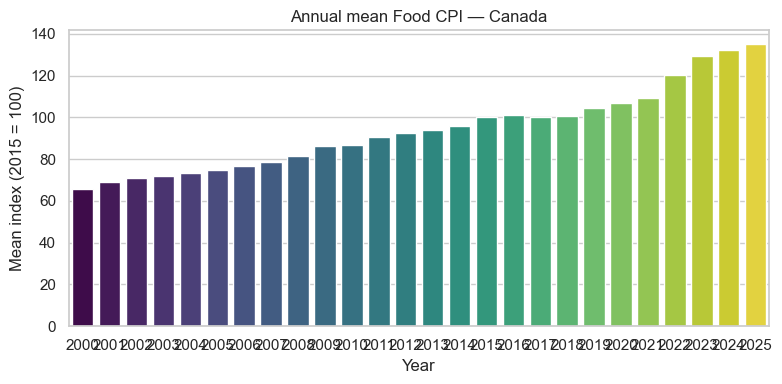

In [16]:

# 1) Time series plot - Canada
plt.figure(figsize=(12,4))
ax = sns.lineplot(data=df_can, x='date', y='Value', marker='o')
ax.set_title('Canada — Consumer Prices, Food Index (2015 = 100)')
ax.set_ylabel('Index (2015 = 100)')
ax.set_xlabel('Date')
plt.tight_layout()
plt.show()

# 2) Monthly seasonality boxplot -Canada
df_can = df_can.copy()
df_can['month_abbr'] = df_can['date'].dt.strftime('%b')
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.figure(figsize=(10,4))
ax = sns.boxplot(x='month_abbr', y='Value', data=df_can, order=month_order)
ax.set_title('Monthly distribution of Food CPI (all years) — Canada')
ax.set_xlabel('Month')
ax.set_ylabel('Index (2015 = 100)')
plt.tight_layout()
plt.show()

# 3) Annual means bar plot - Canada
df_can['year_int'] = df_can['date'].dt.year.astype(int)
annual = df_can.groupby('year_int', as_index=False)['Value'].mean()

plt.figure(figsize=(8,4))
ax = sns.barplot(data=annual, x='year_int', y='Value', hue='year_int', palette='viridis', dodge=False)
ax.set_title('Annual mean Food CPI — Canada')
ax.set_xlabel('Year')
ax.set_ylabel('Mean index (2015 = 100)')
# remove legend built by hue
if ax.get_legend() is not None:
    ax.get_legend().remove()
plt.tight_layout()
plt.show()

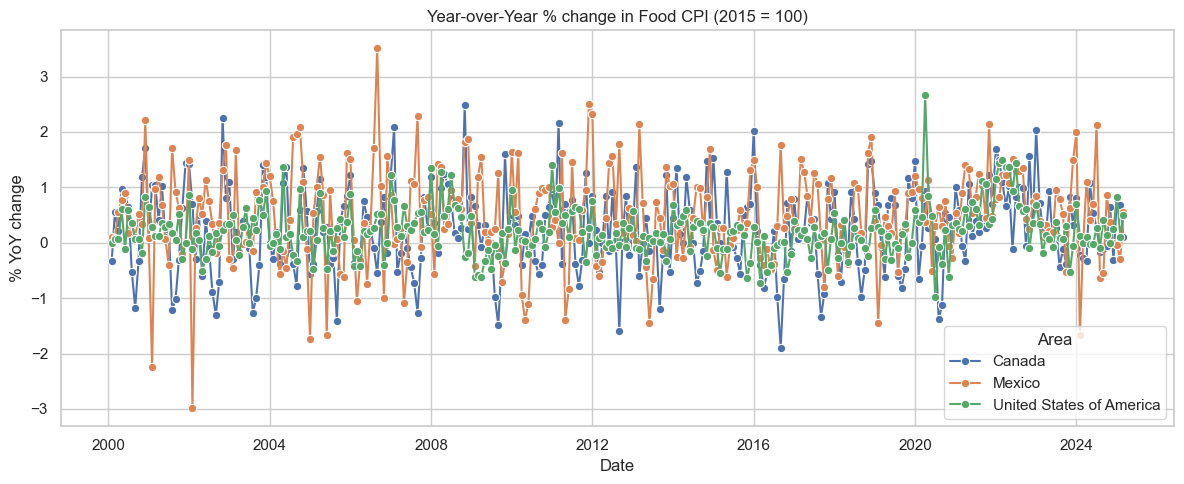

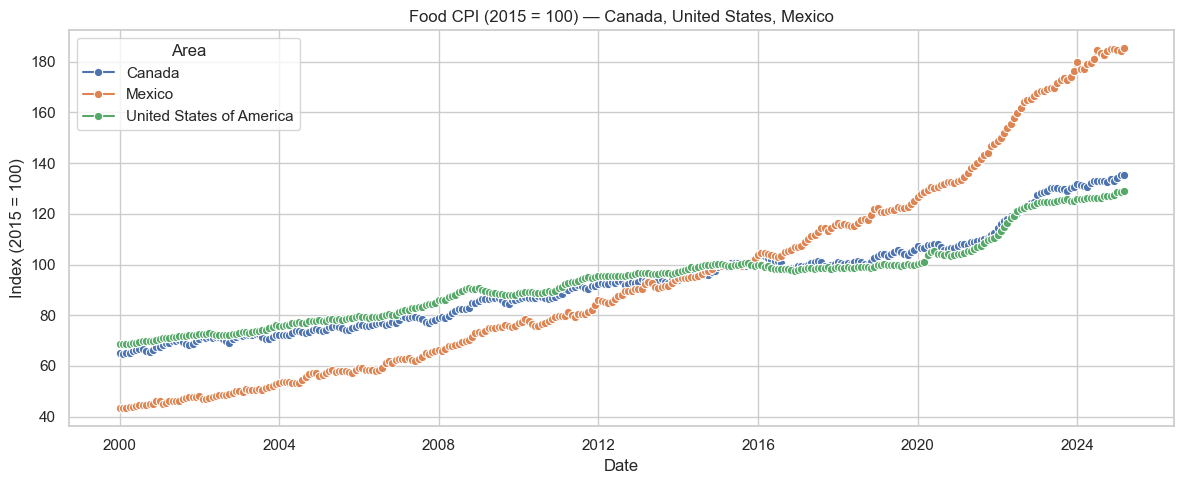

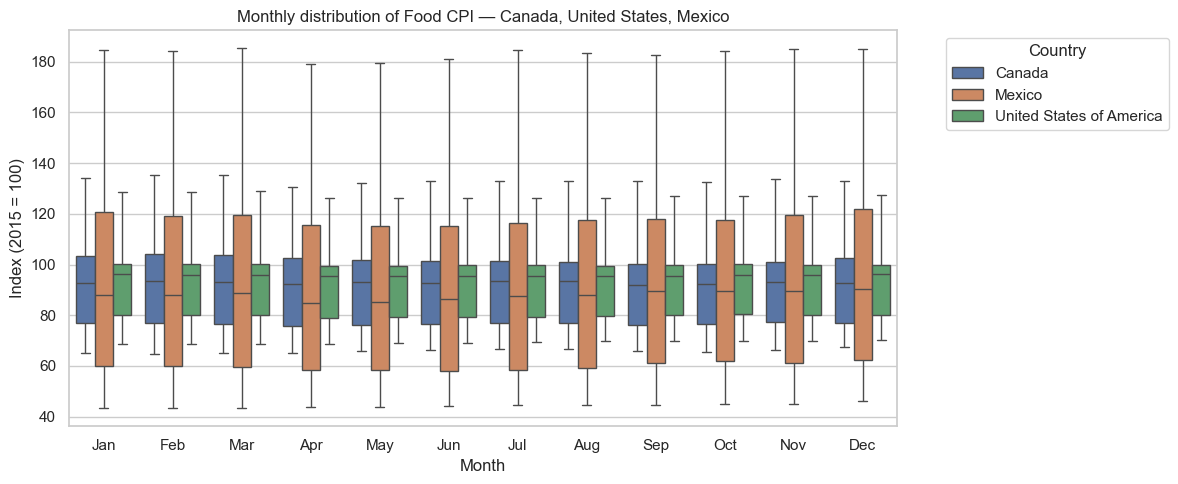

In [17]:

# Combine all
df_all = pd.concat([df_can, df_us, df_mex], ignore_index=True).sort_values(['Area','date']).reset_index(drop=True)
df_all['month_abbr'] = df_all['date'].dt.strftime('%b')

# (a) YoY percent change line plot for each country
df_all = df_all.sort_values(['Area','date']).reset_index(drop=True)
df_all['pct_change'] = df_all.groupby('Area')['Value'].pct_change() * 100

plt.figure(figsize=(12,5))
ax = sns.lineplot(data=df_all, x='date', y='pct_change', hue='Area', marker='o')
ax.set_title('Year-over-Year % change in Food CPI (2015 = 100)')
ax.set_ylabel('% YoY change')
ax.set_xlabel('Date')
plt.tight_layout()
plt.show()

# (b) Multi-country comparison line plot (Index)
plt.figure(figsize=(12,5))
ax = sns.lineplot(data=df_all, x='date', y='Value', hue='Area', marker='o')
ax.set_title('Food CPI (2015 = 100) — Canada, United States, Mexico')
ax.set_ylabel('Index (2015 = 100)')
ax.set_xlabel('Date')
plt.tight_layout()
plt.show()

# (c) Month-over-month boxplot for all three countries combined (seasonality by country)
plt.figure(figsize=(12,5))
ax = sns.boxplot(x='month_abbr', y='Value', hue='Area', data=df_all, order=month_order)
ax.set_title('Monthly distribution of Food CPI — Canada, United States, Mexico')
ax.set_xlabel('Month')
ax.set_ylabel('Index (2015 = 100)')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [19]:
# Save cleaned version of the FAOSTAT CSV 

import os
from pathlib import Path
import shutil
from datetime import datetime

orig_csv = Path("../data/FAOSTAT_data_en_10-14-2025.csv")

if not orig_csv.exists():
    raise FileNotFoundError(f"Original CSV not found: {orig_csv.resolve()}")


df_clean = df.copy()

# filter rows where Item contains 'Food Indices'
mask = df_clean['Item'].str.contains('Food Indices', na=False)
df_clean = df_clean.loc[mask].copy()

# convert Value to numeric and coerce errors to NaN
df_clean['Value'] = pd.to_numeric(df_clean['Value'], errors='coerce')

# Ensure Year is string (so concatenation below works)
df_clean['Year'] = df_clean['Year'].astype(str)

# Parse Year + Months into a single datetime column
df_clean['date'] = pd.to_datetime(
    df_clean['Year'] + ' ' + df_clean['Months'],
    format='%Y %B',
    errors='coerce'
)

# keep only useful columns and drop rows missing date or value
cols_keep = ['date', 'Value', 'Area', 'Item', 'Year', 'Months']
df_clean = df_clean.loc[:, df_clean.columns.intersection(cols_keep)].dropna(subset=['date', 'Value']).copy()

# Sort by date for convenience
df_clean = df_clean.sort_values('date').reset_index(drop=True)


# Write cleaned CSV to original path
df_clean.to_csv(orig_csv, index=False)
print(f"Cleaned CSV written to: {orig_csv}")

print("Cleaned rows:", len(df_clean))
print("Columns in cleaned CSV:", list(df_clean.columns))
print("Sample:")
print(df_clean.head(3).to_string(index=False))

Cleaned CSV written to: ..\data\FAOSTAT_data_en_10-14-2025.csv
Cleaned rows: 909
Columns in cleaned CSV: ['Area', 'Year', 'Item', 'Months', 'Value', 'date']
Sample:
                    Area Year                                       Item  Months     Value       date
                  Canada 2000 Consumer Prices, Food Indices (2015 = 100) January 64.948845 2000-01-01
                  Mexico 2000 Consumer Prices, Food Indices (2015 = 100) January 43.310986 2000-01-01
United States of America 2000 Consumer Prices, Food Indices (2015 = 100) January 68.635462 2000-01-01
